In [1]:
# 04 · Model Comparison — Custom CNN vs MobileNet (PyTorch)
# Compare accuracy, latency, throughput, model size; select a production model and export a report.
import os, json, time, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device and AMP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AMP = torch.cuda.is_available()
print('Torch', torch.__version__, '| TorchVision', torchvision.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print('CUDA runtime:', torch.version.cuda, '| Device:', torch.cuda.get_device_name(0))
    except Exception:
        pass

PROJECT_ROOT = Path.cwd().parents[0]
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
TRAIN_DIR = DATA_RAW / 'Train'
PROC_DIR = PROJECT_ROOT / 'data' / 'processed'
STATS_PATH = PROC_DIR / 'dataset_stats.json'
SPLIT_PATH = PROC_DIR / 'split_indices.json'
MODELS_DIR = PROJECT_ROOT / 'models'
PROD_DIR = PROJECT_ROOT / 'production'
PROD_DIR.mkdir(parents=True, exist_ok=True)

# Defaults; will be overridden by stats file if present
IMG_SIZE = 64
BATCH = 128
NUM_WORKERS = 2
PIN = torch.cuda.is_available()

Torch 2.6.0+cu124 | TorchVision 0.21.0+cu124
CUDA available: True
CUDA runtime: 12.4 | Device: NVIDIA GeForce RTX 3060


In [2]:
# Section 2: Load Validation Dataset and Preprocessing Pipelines (PyTorch)
# Use the same normalization and image size as training; ensure identical class order.
with open(STATS_PATH) as f:
    ds_stats = json.load(f)
DS_MEAN, DS_STD, IMG_SIZE = ds_stats['mean'], ds_stats['std'], ds_stats['img_size']

with open(SPLIT_PATH) as f:
    split = json.load(f)
train_idx = split['train_idx']
val_idx = split['val_idx']

norm = transforms.Normalize(mean=DS_MEAN, std=DS_STD)

def baseline_transform(img_size=IMG_SIZE):
    return transforms.Compose([
        transforms.Resize(int(img_size * 1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        norm,
    ])

# Build datasets with consistent transforms
val_tf = baseline_transform(IMG_SIZE)
train_tf = baseline_transform(IMG_SIZE)  # for quick fine-tuning without aug here

dataset_all_val = datasets.ImageFolder(root=str(TRAIN_DIR), transform=val_tf)
classes = dataset_all_val.classes
n_classes = len(classes)

val_ds = Subset(dataset_all_val, val_idx)

# For MobileNet quick fine-tune (optional)
dataset_all_train = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_tf)
train_ds = Subset(dataset_all_train, train_idx)

BATCH = 128
NUM_WORKERS = 2
PIN = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)

print('Classes:', n_classes, '| Train batches:', len(train_loader), '| Val batches:', len(val_loader))

Classes: 43 | Train batches: 246 | Val batches: 62


In [3]:
# Section 3: Load Trained Models (Custom CNN and MobileNet, PyTorch)
import torch.nn.functional as F
from torchvision.models import mobilenet_v2

# Custom CNN (mirror from training notebook)
class TrafficSignNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256 * 4 * 4, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate
custom_model = TrafficSignNet(n_classes).to(device)

# Load checkpoint from training
ckpt_path = PROJECT_ROOT / 'models' / 'cnn_best.pt'
if ckpt_path.exists():
    ckpt = torch.load(ckpt_path, map_location=device)
    state = ckpt.get('model_state') or ckpt.get('model_state_dict') or ckpt
    custom_model.load_state_dict(state if isinstance(state, dict) else ckpt)
    print('Loaded custom CNN checkpoint:', ckpt_path)
else:
    print('Warning: custom CNN checkpoint not found at', ckpt_path)

custom_model.eval()

# MobileNetV2 head
mbnet = mobilenet_v2(weights='IMAGENET1K_V1')
# Replace classifier head
in_features = mbnet.classifier[-1].in_features
mbnet.classifier[-1] = nn.Linear(in_features, n_classes)
mbnet = mbnet.to(device)

# Optionally fine-tune a few epochs later
print('Custom CNN params:', sum(p.numel() for p in custom_model.parameters())/1e6, 'M')
print('MobileNetV2 params:', sum(p.numel() for p in mbnet.parameters())/1e6, 'M')

Loaded custom CNN checkpoint: f:\VsCodeFolders\Work_Elevvo\Task_5\models\cnn_best.pt


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\PC/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%

Custom CNN params: 1.643467 M
MobileNetV2 params: 2.278955 M


C:\Users\PC\AppData\Local\Temp\ipykernel_18560\561268366.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=AMP):


Val metrics: {'custom_cnn': {'loss': 0.017133696004748344, 'acc': 0.9948992729187012}, 'mobilenet_v2': {'loss': 3.9735100269317627, 'acc': 0.015047181397676468}}


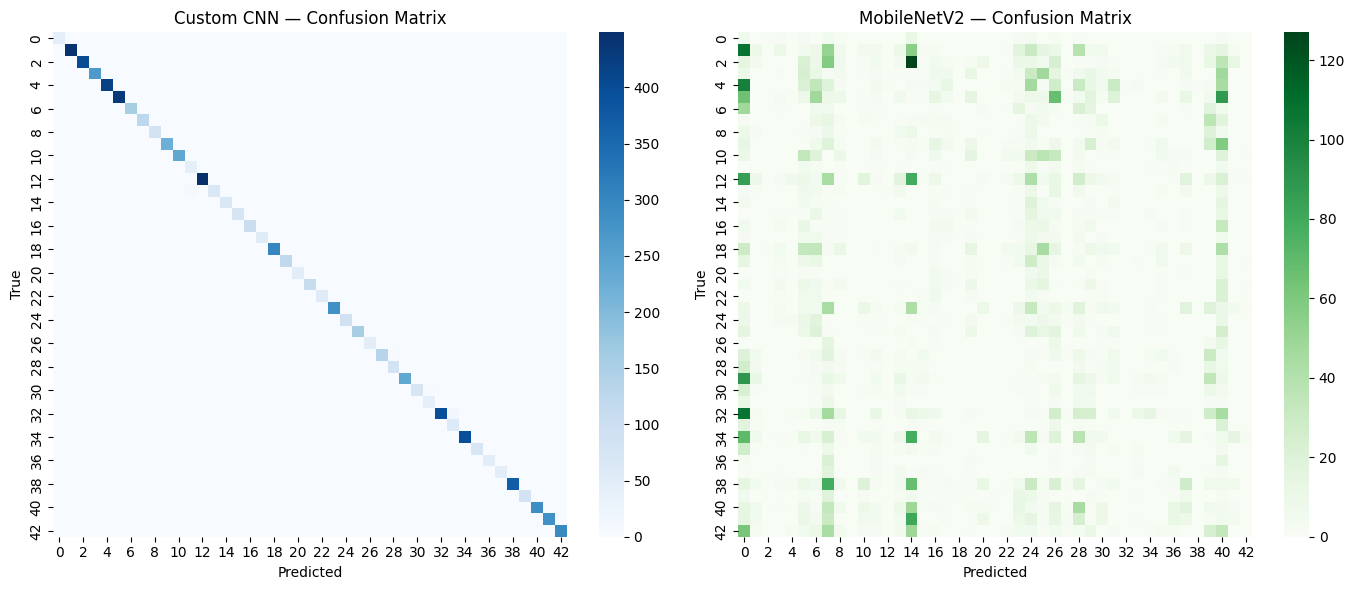

In [4]:
# Section 4: Unified Inference Utilities
from torch.cuda.amp import autocast

def run_inference(model, loader):
    model.eval()
    all_logits, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=torch.cuda.is_available())
            with autocast(enabled=AMP):
                logits = model(xb)
            all_logits.append(logits.float().cpu())
            all_targets.append(yb)
    return torch.cat(all_logits), torch.cat(all_targets)

# Section 5: Accuracy and Loss Evaluation
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    logits_custom, targets = run_inference(custom_model, val_loader)
    loss_custom = criterion(logits_custom, targets)
    preds_custom = logits_custom.argmax(1)
    acc_custom = (preds_custom == targets).float().mean().item()

with torch.no_grad():
    logits_mb, targets_mb = run_inference(mbnet, val_loader)
    loss_mb = criterion(logits_mb, targets_mb)
    preds_mb = logits_mb.argmax(1)
    acc_mb = (preds_mb == targets_mb).float().mean().item()

metrics = {
    'custom_cnn': {'loss': float(loss_custom.item()), 'acc': float(acc_custom)},
    'mobilenet_v2': {'loss': float(loss_mb.item()), 'acc': float(acc_mb)},
}
print('Val metrics:', metrics)

# Section 6: Detailed Classification Metrics
rep_custom = classification_report(targets.numpy(), preds_custom.numpy(), target_names=classes, output_dict=True, zero_division=0)
rep_mb = classification_report(targets_mb.numpy(), preds_mb.numpy(), target_names=classes, output_dict=True, zero_division=0)

cm_custom = confusion_matrix(targets.numpy(), preds_custom.numpy())
cm_mb = confusion_matrix(targets_mb.numpy(), preds_mb.numpy())

fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_custom, ax=axes[0], cmap='Blues', cbar=True)
axes[0].set_title('Custom CNN — Confusion Matrix')
sns.heatmap(cm_mb, ax=axes[1], cmap='Greens', cbar=True)
axes[1].set_title('MobileNetV2 — Confusion Matrix')
for ax in axes:
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
plt.tight_layout(); plt.show()

# Save raw reports
(MODELS_DIR / 'reports').mkdir(parents=True, exist_ok=True)
with open(MODELS_DIR / 'reports' / 'val_reports.json', 'w') as f:
    json.dump({'custom_cnn': rep_custom, 'mobilenet_v2': rep_mb, 'metrics': metrics}, f, indent=2)

In [5]:
# Section 7: Performance Benchmarking (Latency and Throughput)
import statistics

def benchmark_model(model, loader, warmup=5, repeats=30):
    model.eval()
    times = []
    it = iter(loader)
    # warmup
    with torch.no_grad():
        for _ in range(warmup):
            try:
                xb, _ = next(it)
            except StopIteration:
                it = iter(loader); xb, _ = next(it)
            xb = xb.to(device, non_blocking=torch.cuda.is_available())
            with autocast(enabled=AMP):
                _ = model(xb)
    # measure
    with torch.no_grad():
        for _ in range(repeats):
            try:
                xb, _ = next(it)
            except StopIteration:
                it = iter(loader); xb, _ = next(it)
            xb = xb.to(device, non_blocking=torch.cuda.is_available())
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            t0 = time.perf_counter()
            with autocast(enabled=AMP):
                _ = model(xb)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            dt = time.perf_counter() - t0
            times.append(dt)
    bs = xb.size(0)
    lat_mean = statistics.mean(times)
    lat_p95 = np.percentile(times, 95)
    thrpt = bs / lat_mean
    return {'latency_s_mean': lat_mean, 'latency_s_p95': float(lat_p95), 'throughput_ips': thrpt, 'batch_size': bs}

bench_custom = benchmark_model(custom_model, val_loader)
bench_mb = benchmark_model(mbnet, val_loader)
print('Benchmark custom:', bench_custom)
print('Benchmark mobile:', bench_mb)

# Section 8: Model Size and Complexity Metrics
custom_params = sum(p.numel() for p in custom_model.parameters())
mb_params = sum(p.numel() for p in mbnet.parameters())

ckpt_size = os.path.getsize(ckpt_path) / 1e6 if ckpt_path.exists() else None
# No MobileNet checkpoint yet; if saved later we can compute
size_summary = {
    'custom_cnn': {'params': int(custom_params), 'ckpt_mb': ckpt_size},
    'mobilenet_v2': {'params': int(mb_params), 'ckpt_mb': None},
}
print('Size summary:', size_summary)

# Section 9: Edge Conversion (Note)
print('Note: For TFLite, consider exporting to ONNX, then converting to TensorRT or TFLite via ONNX -> tf -> tflite. Skipping heavy conversion in this notebook for simplicity.')

# Section 10: Production-Oriented Model Selection
# Define weighted score using accuracy (primary), latency, and size.
from math import isfinite

sel = {}
for name, acc, bench, sz in [
    ('custom_cnn', acc_custom, bench_custom, size_summary['custom_cnn']),
    ('mobilenet_v2', acc_mb, bench_mb, size_summary['mobilenet_v2']),
]:
    lat = bench['latency_s_mean']
    params = sz['params']
    # Normalize (min-max over two models)
    sel[name] = {'acc': acc, 'lat': lat, 'params': params}

accs = [v['acc'] for v in sel.values()]
lats = [v['lat'] for v in sel.values()]
pars = [v['params'] for v in sel.values()]

acc_min, acc_max = min(accs), max(accs)
lat_min, lat_max = min(lats), max(lats)
par_min, par_max = min(pars), max(pars)

def norm(x, lo, hi, higher_is_better=True):
    if hi == lo:
        return 1.0
    s = (x - lo) / (hi - lo)
    return s if higher_is_better else 1.0 - s

weights = {'acc': 0.6, 'lat': 0.25, 'params': 0.15}
for k, v in sel.items():
    score = (
        weights['acc'] * norm(v['acc'], acc_min, acc_max, True) +
        weights['lat'] * norm(v['lat'], lat_min, lat_max, False) +
        weights['params'] * norm(v['params'], par_min, par_max, False)
    )
    v['score'] = float(score)

winner = max(sel.items(), key=lambda kv: kv[1]['score'])[0]
print('Selection scores:', sel)
print('Selected for production:', winner)

# Section 11: Final Evaluation and Report Export
report = {
    'val_metrics': metrics,
    'benchmarks': {'custom_cnn': bench_custom, 'mobilenet_v2': bench_mb},
    'size': size_summary,
    'selection': sel,
    'winner': winner,
    'classes': classes,
}
with open(PROJECT_ROOT / 'models' / 'reports' / 'model_comparison.json', 'w') as f:
    json.dump(report, f, indent=2)

# Export winner artifact
if winner == 'custom_cnn' and ckpt_path.exists():
    dst = PROD_DIR / 'model.pt'
    torch.save({'model_state': custom_model.state_dict(), 'classes': classes, 'img_size': IMG_SIZE}, dst)
    print('Exported production model to', dst)
else:
    # Save MobileNet head state dict (requires re-creation in prod)
    dst = PROD_DIR / 'mobilenet_head.pt'
    torch.save({'model_state': mbnet.state_dict(), 'classes': classes, 'img_size': IMG_SIZE}, dst)
    print('Exported MobileNet weights to', dst)

C:\Users\PC\AppData\Local\Temp\ipykernel_18560\365905893.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=AMP):
C:\Users\PC\AppData\Local\Temp\ipykernel_18560\365905893.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=AMP):
C:\Users\PC\AppData\Local\Temp\ipykernel_18560\365905893.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=AMP):


Benchmark custom: {'latency_s_mean': 0.007404823332035448, 'latency_s_p95': 0.007902705001470167, 'throughput_ips': 17286.03023467613, 'batch_size': 128}
Benchmark mobile: {'latency_s_mean': 0.008675896665954497, 'latency_s_p95': 0.011089474995242196, 'throughput_ips': 14753.518273481857, 'batch_size': 128}
Size summary: {'custom_cnn': {'params': 1643467, 'ckpt_mb': 6.597616}, 'mobilenet_v2': {'params': 2278955, 'ckpt_mb': None}}
Note: For TFLite, consider exporting to ONNX, then converting to TensorRT or TFLite via ONNX -> tf -> tflite. Skipping heavy conversion in this notebook for simplicity.
Selection scores: {'custom_cnn': {'acc': 0.9948992729187012, 'lat': 0.007404823332035448, 'params': 1643467, 'score': 1.0}, 'mobilenet_v2': {'acc': 0.015047181397676468, 'lat': 0.008675896665954497, 'params': 2278955, 'score': 0.0}}
Selected for production: custom_cnn
Exported production model to f:\VsCodeFolders\Work_Elevvo\Task_5\production\model.pt


In [6]:
# Section 3.1: Quick MobileNetV2 Fine-tune (few epochs)
EPOCHS_FT = 3
for p in mbnet.features.parameters():
    p.requires_grad = False  # train classifier only for speed

opt_ft = torch.optim.Adam(filter(lambda p: p.requires_grad, mbnet.parameters()), lr=1e-3)
crit_ft = nn.CrossEntropyLoss()
scaler_ft = torch.cuda.amp.GradScaler(enabled=AMP)

best_va = 0.0
mb_ckpt_path = PROJECT_ROOT / 'models' / 'mobilenet_finetuned.pt'

for epoch in range(1, EPOCHS_FT + 1):
    mbnet.train()
    tr_loss, tr_correct, tr_total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=torch.cuda.is_available())
        yb = yb.to(device, non_blocking=torch.cuda.is_available())
        opt_ft.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=AMP):
            logits = mbnet(xb)
            loss = crit_ft(logits, yb)
        scaler_ft.scale(loss).backward()
        scaler_ft.step(opt_ft)
        scaler_ft.update()
        tr_loss += loss.item() * xb.size(0)
        tr_correct += logits.argmax(1).eq(yb).sum().item()
        tr_total += yb.size(0)

    # simple val
    mbnet.eval()
    va_correct, va_total, va_loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=torch.cuda.is_available())
            yb = yb.to(device, non_blocking=torch.cuda.is_available())
            with torch.cuda.amp.autocast(enabled=AMP):
                logits = mbnet(xb)
                loss = crit_ft(logits, yb)
            va_loss_sum += loss.item() * xb.size(0)
            va_correct += logits.argmax(1).eq(yb).sum().item()
            va_total += yb.size(0)

    tr_loss /= max(tr_total, 1)
    va_loss = va_loss_sum / max(va_total, 1)
    tr_acc = tr_correct / max(tr_total, 1)
    va_acc = va_correct / max(va_total, 1)
    print(f"[MobileNet FT] Epoch {epoch}/{EPOCHS_FT} - tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

    if va_acc > best_va:
        best_va = va_acc
        torch.save({'model_state': mbnet.state_dict(), 'classes': classes, 'img_size': IMG_SIZE}, mb_ckpt_path)
        print('Saved new best MobileNet checkpoint ->', mb_ckpt_path)

# Load best
if mb_ckpt_path.exists():
    sd = torch.load(mb_ckpt_path, map_location=device)
    state = sd.get('model_state') or sd
    mbnet.load_state_dict(state)
    print('Loaded finetuned MobileNet weights.')

C:\Users\PC\AppData\Local\Temp\ipykernel_18560\2039357779.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_ft = torch.cuda.amp.GradScaler(enabled=AMP)
C:\Users\PC\AppData\Local\Temp\ipykernel_18560\2039357779.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP):
C:\Users\PC\AppData\Local\Temp\ipykernel_18560\2039357779.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP):
C:\Users\PC\AppData\Local\Temp\ipykernel_18560\2039357779.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP):
C:\Users\PC\AppData\Local\Temp\ipykernel_18560\2039357779

[MobileNet FT] Epoch 1/3 - tr_loss=1.6018 tr_acc=0.5461 | val_loss=1.1164 val_acc=0.6817
Saved new best MobileNet checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\mobilenet_finetuned.pt
[MobileNet FT] Epoch 2/3 - tr_loss=1.0427 tr_acc=0.6807 | val_loss=0.9241 val_acc=0.7249
Saved new best MobileNet checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\mobilenet_finetuned.pt
[MobileNet FT] Epoch 2/3 - tr_loss=1.0427 tr_acc=0.6807 | val_loss=0.9241 val_acc=0.7249
Saved new best MobileNet checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\mobilenet_finetuned.pt
[MobileNet FT] Epoch 3/3 - tr_loss=0.9117 tr_acc=0.7147 | val_loss=0.8462 val_acc=0.7541
Saved new best MobileNet checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\mobilenet_finetuned.pt
Loaded finetuned MobileNet weights.
[MobileNet FT] Epoch 3/3 - tr_loss=0.9117 tr_acc=0.7147 | val_loss=0.8462 val_acc=0.7541
Saved new best MobileNet checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\mobilenet_finetun